In [75]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/2n")
dir = os.path.join(pickledir, "images_2n_wc_var")

print(dir)

def get_period(timeseries, dt):
    peaks = scipy.signal.find_peaks(timeseries, prominence=0.001)[0]
    periods = []
    for i in range(1, len(peaks)-1):
        periods.append( (peaks[i] - peaks[i-1]) * dt)
    return np.mean(periods)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/2n/images_2n_wc_var


In [3]:
p_names = ["Osc", "Bi-phase-osc", "Beat", "Bi-period-osc", "Bi-stat-osc"]
coords = [[1.1, 0.3], [1.8, 0.8], [1.4, 0.6], [1.1, 0.5], [2.1, 0.8]]

for i in range(len(p_names)):
    p = p_names[i]
    data[p]["coordinates"] = coords[i]

NameError: name 'data' is not defined

In [44]:
def plotspectrum(data, fmax=1., ymax = 100, filename=None):

    for d in data:
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)]

        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

        plt.plot(fr, ps_plot)

    plt.xlim(-0.01,fmax)
    plt.ylim(0,ymax)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))
    
    plt.show()

    maxfreqind = np.where(ps_plot == max(ps_plot[1:]))
    print("freq of max = ", fr[maxfreqind])
    print("period of max = ", 1./fr[maxfreqind])

    return (1./fr[maxfreqind])[0]

def plot_EI_trajectory(m, tstart= 10000, filename=None):

    plt.plot(m.exc[0,tstart:], m.inh[0,tstart:], color="gray", linewidth=1)
    #plt.plot(m.exc[1,tstart:], m.inh[1,tstart:], color="gray", linewidth=2, linestyle=":")

    plt.xlabel("E")
    plt.ylabel("I")
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))


    plt.show()

    return

def recurrence_plot(data, threshold=0.01):
    N = len(data)
    distance_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distance_matrix[i, j] = np.abs(data[i] - data[j])

    # Create the recurrence plot
    recurrence_plot = np.where(distance_matrix <= threshold, 1, 0)

    return recurrence_plot

def show_recplot(data, threshold=0.1):
    plt.figure(figsize=(8, 8))
    recurrence=recurrence_plot(data, threshold)
    plt.imshow(recurrence, cmap='binary', origin='lower')
    plt.title('Recurrence Plot')
    plt.xlabel('Time')
    plt.ylabel('Time')
    plt.colorbar(label='Recurrence')
    plt.show()

    return


Bi-stat-osc


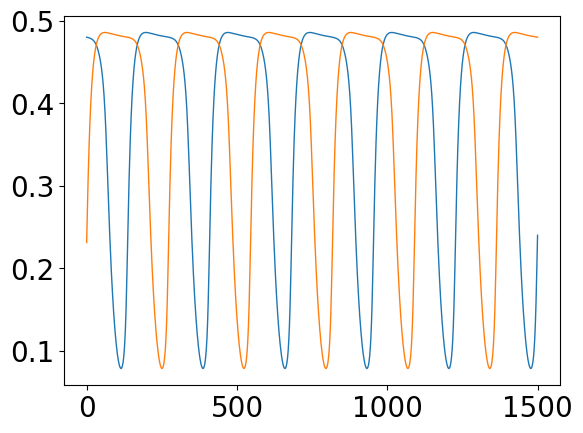

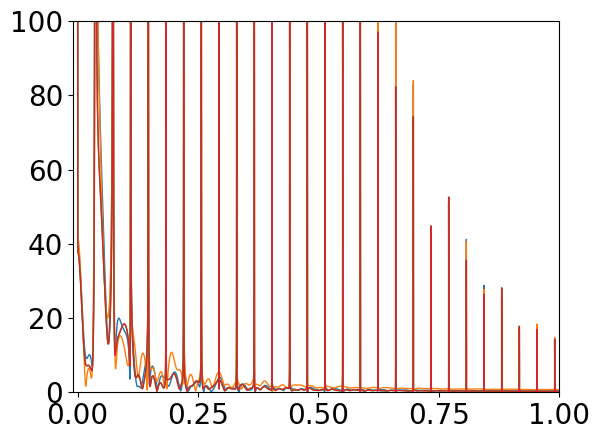

freq of max =  [0.03670007]
period of max =  [27.24790191]


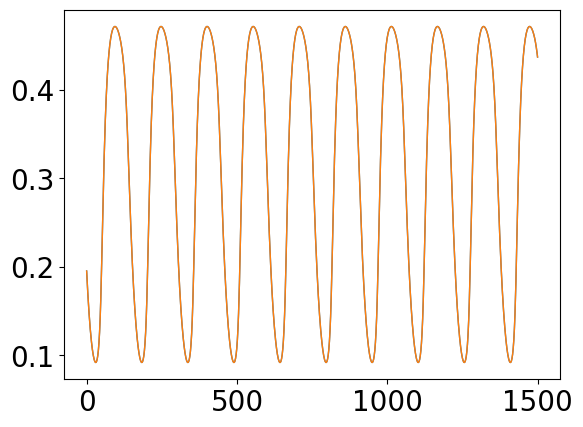

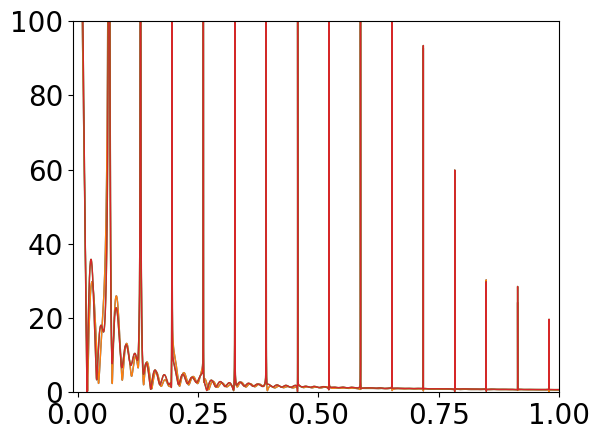

freq of max =  [0.06529013]
period of max =  [15.31625057]


In [89]:
coupling = 1.8
cmat = np.array( [[0., 1.], [1., 0.]] )
N = cmat.shape[0]

if True:
    data = dict()

    for i in range(len(p_names)):
        p = p_names[i]
        data[p] = dict()
        data[p]["coordinates"] = coords[i]
        data[p]["delay"] = 9.5

        if "Bi-period" in p:
            data[p]["control"] = [[None, None], [None, None]]
            data[p]["state"] = [[None, None], [None, None]]
            data[p]["init_state"] = [None, None]
            data[p]["weight"] = [[1., 1.], [1., 1.]]
            data[p]["dur/per"] = [[1000., 20], [1000., 20]]
            data[p]["target_period"] = [20., 20.]
        elif p == "Osc":
            data[p]["delay"] = 1.
            data[p]["control"] = [None, None]
            data[p]["state"] = [None, None]
            data[p]["init_state"] = None
            data[p]["weight"] = [1., 1.]
            data[p]["dur/per"] = [1000., 20]
            data[p]["target_period"] = 20.
        else:
            data[p]["control"] = [None, None]
            data[p]["state"] = [None, None]
            data[p]["init_state"] = None
            data[p]["weight"] = [1., 1.]
            data[p]["dur/per"] = [1000., 20]
            data[p]["target_period"] = 20.


duration = 100000.
dt = 0.1
data["Osc"]["delay"] = 3.

test_input_plus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_plus[:,:int(50/dt)] = 5.

test_input_minus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_minus[:,:int(50/dt)] = -5.

test_input_phase = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_phase = np.vstack( ([test_input_phase]*N))
test_input_phase[0,:int(50/dt)] = np.sin(2.*np.pi*np.arange(0,50,dt)/20.)
test_input_phase[1,:int(50/dt)] = - np.sin(2.*np.pi*np.arange(0,50,dt)/20.)

test_inputin__phase = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_inputin__phase = np.vstack( ([test_input_phase]*N))
test_inputin__phase[0,:int(50/dt)] = np.sin(2.*np.pi*np.arange(0,50,dt)/20.)
test_inputin__phase[1,:int(50/dt)] = np.sin(2.*np.pi*np.arange(0,50,dt)/20.)

for pi in range(len(p_names)):

    if "Bi" in p_names[pi]:
        continue

    break

    print(p_names[pi], data[p_names[pi]]["delay"])

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p_names[pi]]["coordinates"][0]
    model.params.inh_ext_baseline = data[p_names[pi]]["coordinates"][1]
    #model.params["exc_ext"] = test_input_minus
    # minus: async after long time / beat after long time
    # plus: async after long time / beat after long time
    # none: async after long time / beat after long time

    model.params["exc_ext"] = test_input_minus

    model.params.K_gl = coupling
    model.run()
    nmaxdelay = model.getMaxDelay()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p_names[pi]]["init_state"] = [einit, iinit]

    plt.plot(model.exc[0,-3000:])
    plt.plot(model.exc[1,-3000:])
    plt.show()

    plt.plot(model.exc[0,3000:6000])
    plt.plot(model.exc[1,3000:6000])
    plt.show()

    data[p_names[pi]]["target_period"] = plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]], fmax=0.3, filename="beat_spectrum")
    plot_EI_trajectory(model, filename="beat_trajectory")
    #show_recplot(model.exc[0,90000:], threshold=0.1)

if False:
    p = "Bi-phase-osc"

    print(p)

    model = WCModel(Cmat=cmat, Dmat=data[p]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.dt = dt
    model.params.exc_ext_baseline = data[p]["coordinates"][0]
    model.params.inh_ext_baseline = data[p]["coordinates"][1]
    model.params.K_gl = coupling
    nmaxdelay = model.getMaxDelay()

    model.params["exc_ext"] = test_input_phase
    model.run()

    plt.plot(model.exc[0,-int(150/dt):])
    plt.plot(model.exc[1,-int(150/dt):])
    plt.show()

    data[p]["target_period"] = plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]])

    model.params["exc_ext"] = test_inputin__phase
    model.run()

    plt.plot(model.exc[0,-int(150/dt):])
    plt.plot(model.exc[1,-int(150/dt):])
    plt.show()

    plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]])

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p]["init_state"] = [einit, iinit]

##########################################

if True:
    p = "Bi-stat-osc"

    print(p)

    model = WCModel(Cmat=cmat, Dmat=data[p]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.dt = dt
    model.params.exc_ext_baseline = data[p]["coordinates"][0]
    model.params.inh_ext_baseline = data[p]["coordinates"][1]
    model.params.K_gl = coupling
    nmaxdelay = model.getMaxDelay()

    model.params["exc_ext"] = test_input_phase
    model.run()

    plt.plot(model.exc[0,-int(150/dt):])
    plt.plot(model.exc[1,-int(150/dt):])
    plt.show()

    plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]])

    model.params["exc_ext"] = test_input_minus
    model.run()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p]["init_state"] = [einit, iinit]

    plt.plot(model.exc[0,-int(150/dt):])
    plt.plot(model.exc[1,-int(150/dt):])
    plt.show()

    data[p]["target_period"] = plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]])

##########################################
if False:
    p = "Bi-period-osc"

    print(p)

    model = WCModel(Cmat=cmat, Dmat=data[p]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p]["coordinates"][0]
    model.params.inh_ext_baseline = data[p]["coordinates"][1]
    model.params.K_gl = coupling
    nmaxdelay = model.getMaxDelay()

    model.params["exc_ext"] = test_input_plus
    model.run()

    plt.plot(model.exc[0,-1500:])
    plt.plot(model.exc[1,-1500:])
    plt.show()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p]["init_state"][0] = [einit, iinit]

    model.params["exc_ext"] = test_input_phase
    model.run()

    tp0 = plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]])

    model.params["exc_ext"] = test_input_plus
    model.run()

    plt.plot(model.exc[0,-1500:])
    plt.plot(model.exc[1,-1500:])
    plt.show()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p]["init_state"][1] = [einit, iinit]

    model.params["exc_ext"] = test_input_minus
    model.run()

    tp1 = plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]])
    
    data[p]["target_period"] = [tp0, tp1]

In [19]:
print(27.10026558/27.24790191)
15.16070042/15.31625057

0.9945817358529973


0.9898441103918294

In [21]:
controlmat = np.ones((N,2))

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

it = 50
maxstr = 5

pr = np.arange(0,1001,20)
testd = 1000.

zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

In [22]:
def optimize_model(model, exprange):
    for l in range(2):
        for k in exprange:
            model.zero_step_encountered = False
            model.step = 10**(k)
            model.optimize(it)
        model.control_matrix = controlmat
    model.zero_step_encountered = False

    return

In [83]:
data["Osc"]["weight"] = [1., 1. * 1e1]   #5, 4 too small
data["Bi-phase-osc"]["weight"] = [1., 50.] # 5 * 1e-6 (1,2,4,6,8) * 1e-5, (2,4,5))*1e-4, 1e-3 good
data["Beat"]["weight"] = [1. * 1e-4, 1. * 1e-3]
data["Bi-stat-osc"]["weight"] = [1. , 1. * 1e-3]

data["Osc"]["dur/per"] = [450., 20]
data["Bi-phase-osc"]["dur/per"] = [400., 20]
data["Beat"]["dur/per"] = [1000., 40]
data["Bi-stat-osc"]["dur/per"] = [400., 20]

Point  Bi-stat-osc
target period, max delay =  [15.316250574360545, 13.623950955] 95
duration =  1000.0
w2 =  1.0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.0
Converged in iteration 1 with cost 0.0
Final cost : 0.0


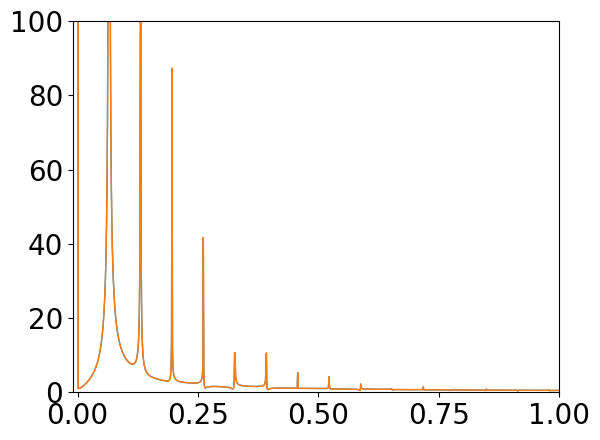

freq of max =  [0.065013]
period of max =  [15.38153846]
Compute control for a deterministic system
Cost in iteration 0: 0.0
Converged in iteration 1 with cost 0.0
Final cost : 0.0
Compute control for a deterministic system
Cost in iteration 0: 0.0
Converged in iteration 1 with cost 0.0
Final cost : 0.0
Compute control for a deterministic system
Cost in iteration 0: 0.0
Converged in iteration 1 with cost 0.0
Final cost : 0.0
Compute control for a deterministic system
Cost in iteration 0: 0.0
Converged in iteration 1 with cost 0.0
Final cost : 0.0
Compute control for a deterministic system
Cost in iteration 0: 0.0
Converged in iteration 1 with cost 0.0
Final cost : 0.0
Compute control for a deterministic system
Cost in iteration 0: 0.0
Converged in iteration 1 with cost 0.0
Final cost : 0.0
Compute control for a deterministic system
Cost in iteration 0: 0.0
Converged in iteration 1 with cost 0.0
Final cost : 0.0
Compute control for a deterministic system
Cost in iteration 0: 0.0
Converg

/tmp/ipykernel_503461/1939093245.py:34: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[1,0].set_ylim(y1lim)


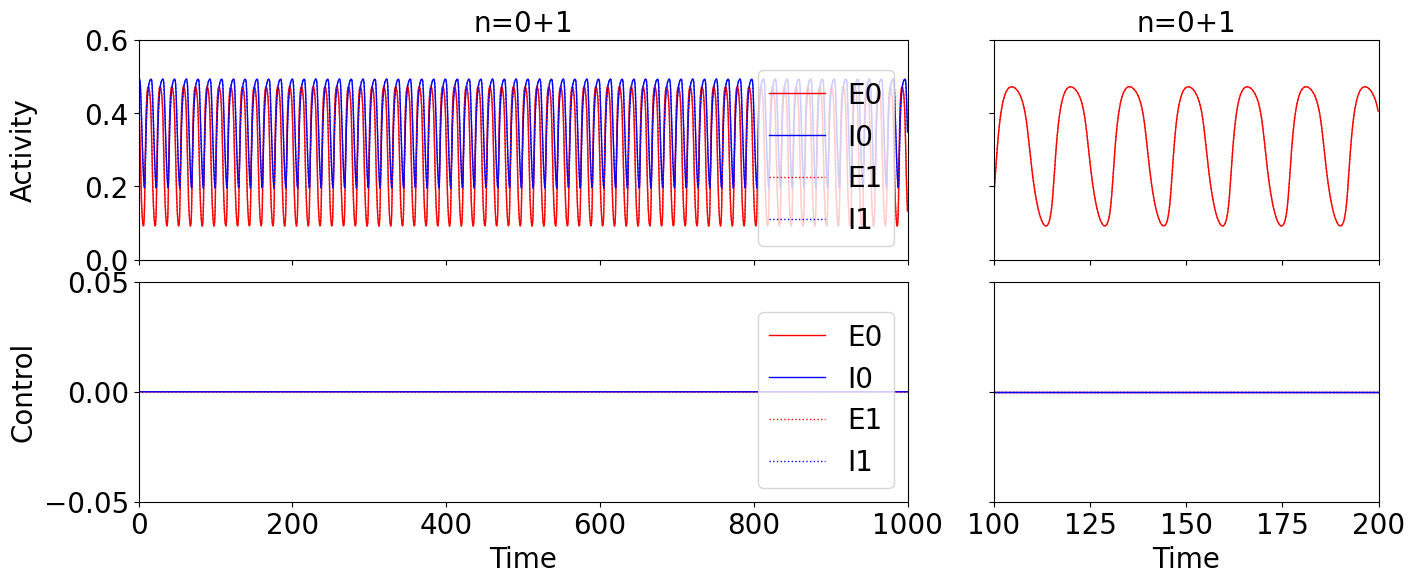

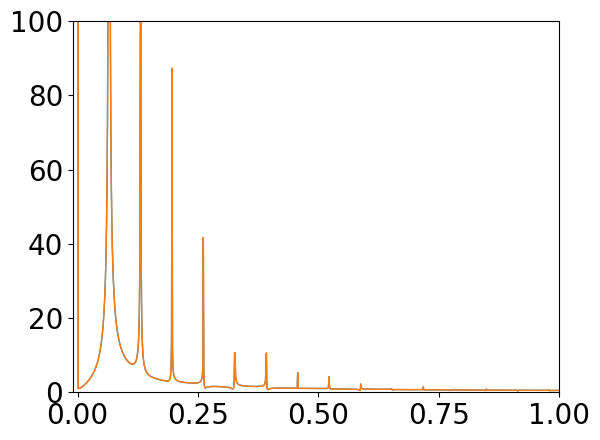

freq of max =  [0.065013]
period of max =  [15.38153846]


In [92]:
it = 20


for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" in p:
        continue

    if pi not in [4]: continue

    print("Point ", p)
      
    target_period = [data[p]["target_period"], 0.5 * 27.24790191]
    #target_period = 1e10

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
    nmaxdelay = model.getMaxDelay()
    print("target period, max delay = ", target_period, nmaxdelay)

    model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
    model.params.K_gl = coupling

    model.params.duration = data[p]["dur/per"][0]
    print("duration = ", model.params.duration)

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))
    zero_control = np.vstack( ([zero_input]*N))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]
    model.run()

    model.params["exc_init"] = data[p]["init_state"][0]
    model.params["inh_init"] = data[p]["init_state"][1]

    model.run()
    
    int0 = 200
    int1 = 1000

    for wi, w2 in enumerate(data[p]["weight"]):

        if wi not in [0]: continue

        print("w2 = ",w2)

        #for factor in np.random.random(3):
        for factor in [1]:

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int1,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2 * factor * 1e-2
            model_controlled.weights["w_var"] = -1

            model_controlled.maximum_control_strength = maxstr

            if False:
                if type(data[p]["control"][wi]) != type(None):
                    model_controlled.control = data[p]["control"][wi].copy()
                    model_controlled.update_input()
            
            model_controlled.optimize(1)

            plotspectrum( [model_controlled.model.exc[0,:], model_controlled.model.exc[1,:]])

            #model_controlled.control[0,0,:600] = 1.
            #model_controlled.update_input()
            #model_controlled.optimize(0)

            for j in range(1):
                model_controlled.grad_method = 0
                model_controlled.channelwise_optimization = True

                for l in range(1):
                    for k in np.arange(12., 17., 2.):
                        model_controlled.zero_step_encountered = False
                        model_controlled.step = 10**(k)
                        model_controlled.optimize(it)

                for l in range(1):
                    for k in np.arange(-7., 7., 2.):
                        model_controlled.zero_step_encountered = False
                        model_controlled.step = 10**(k)
                        model_controlled.optimize(it)

                model_controlled.grad_method = 1
                model_controlled.channelwise_optimization = True

                for l in range(0):
                    for k in np.arange(-7., 7., 2.):
                        model_controlled.zero_step_encountered = False
                        model_controlled.step = 10**(k)
                        model_controlled.optimize(10)

            data[p]["control"][wi] = model_controlled.control.copy()
            data[p]["state"][wi] = model_controlled.get_xs()

        if False:

            mod = copy.deepcopy(model_controlled.model)
            mod.params.duration = 1200.
            input = np.zeros((2,2,1+int(mod.params.duration/dt)))
            input[:,:,:1+int(data[p]["dur/per"][0]/dt)] = model_controlled.control.copy()
            mod.params.exc_ext = input[:,0,:]
            mod.params.inh_ext = input[:,1,:]
            mod.run()

            plt.plot(np.arange(0,mod.params.duration,dt), mod.exc[0,:], color="red")
            plt.plot(np.arange(0,mod.params.duration,dt), mod.exc[1,:], color="red", linestyle=":")
            plt.ylim(0,0.5)
            plt.show()

        plot_control_1(data[p]["control"][wi], data[p]["state"][wi], data[p]["dur/per"][0], dt, filename=os.path.join(dir, "IPosc_up.png"))
        plotspectrum( [model_controlled.model.exc[0,:], model_controlled.model.exc[1,:]])

#with open(os.path.join(pickledir, '2n_wc_oscillations_var.pickle'), 'wb') as f:
#    pickle.dump(data, f)

Point  Osc
10.0


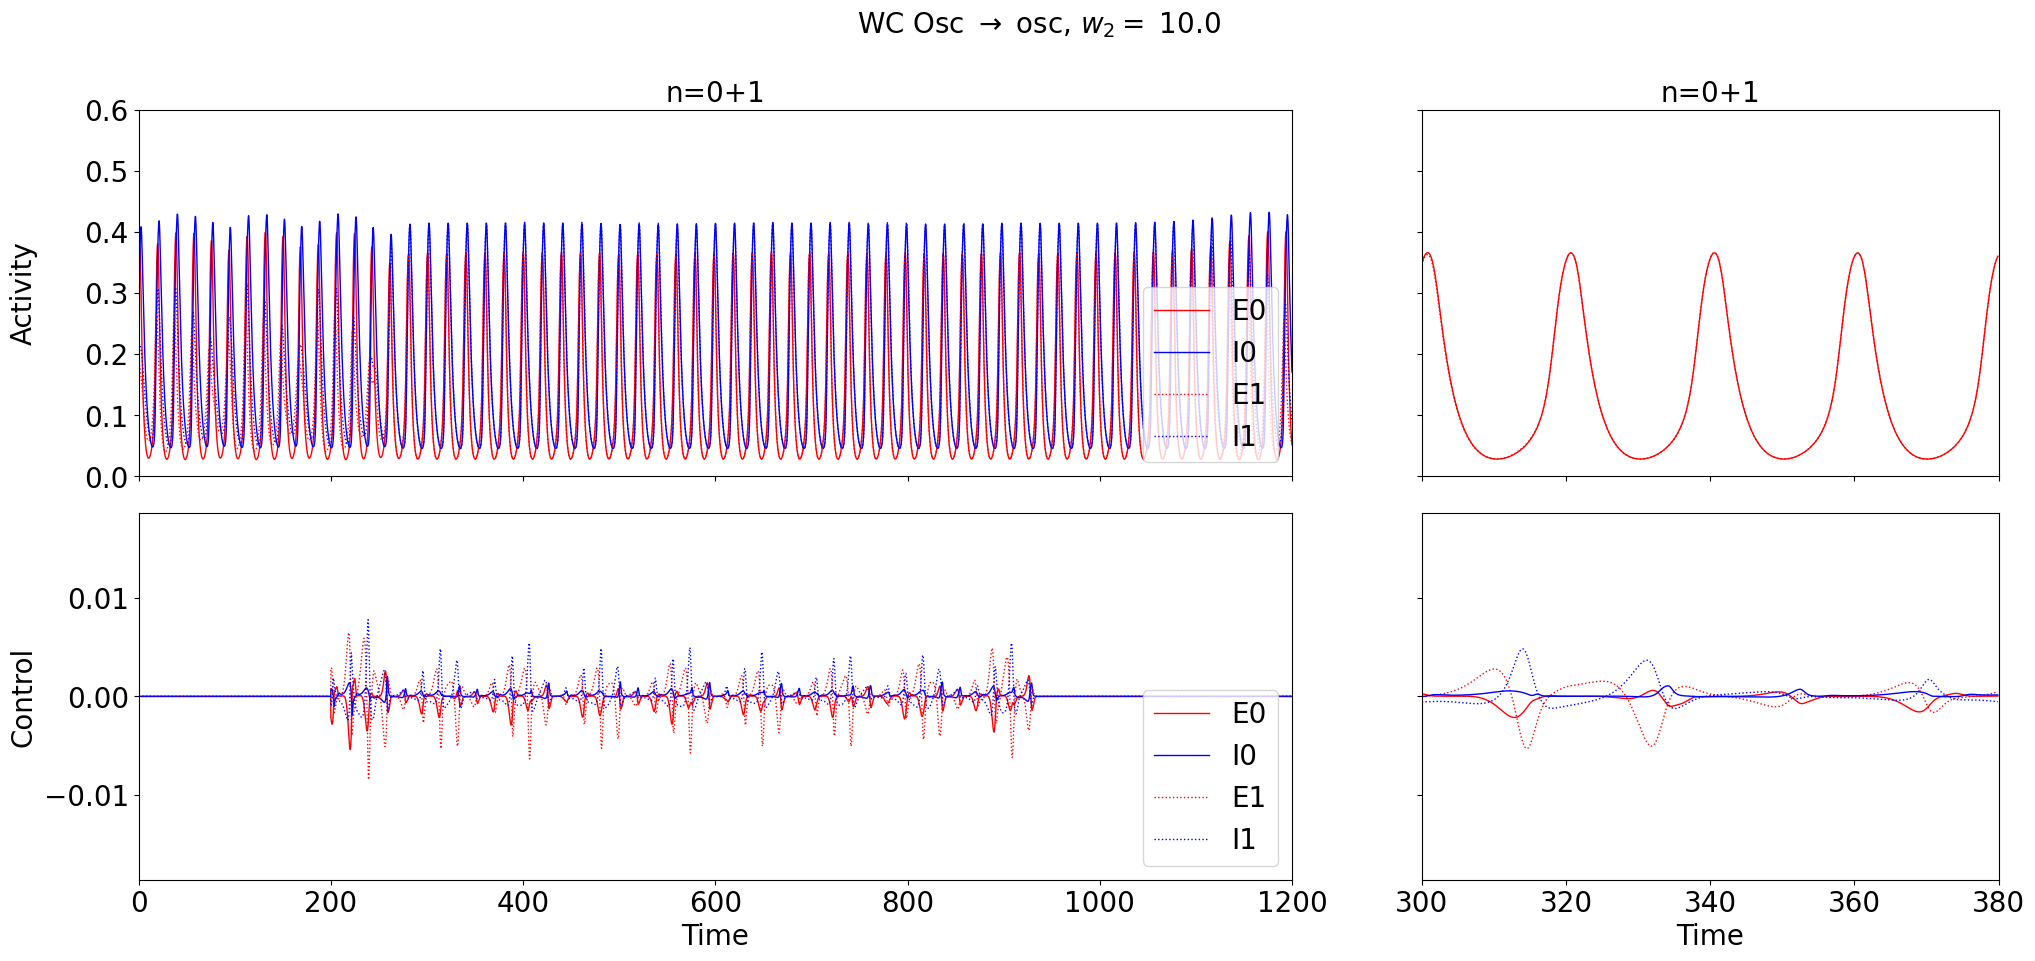

100.0


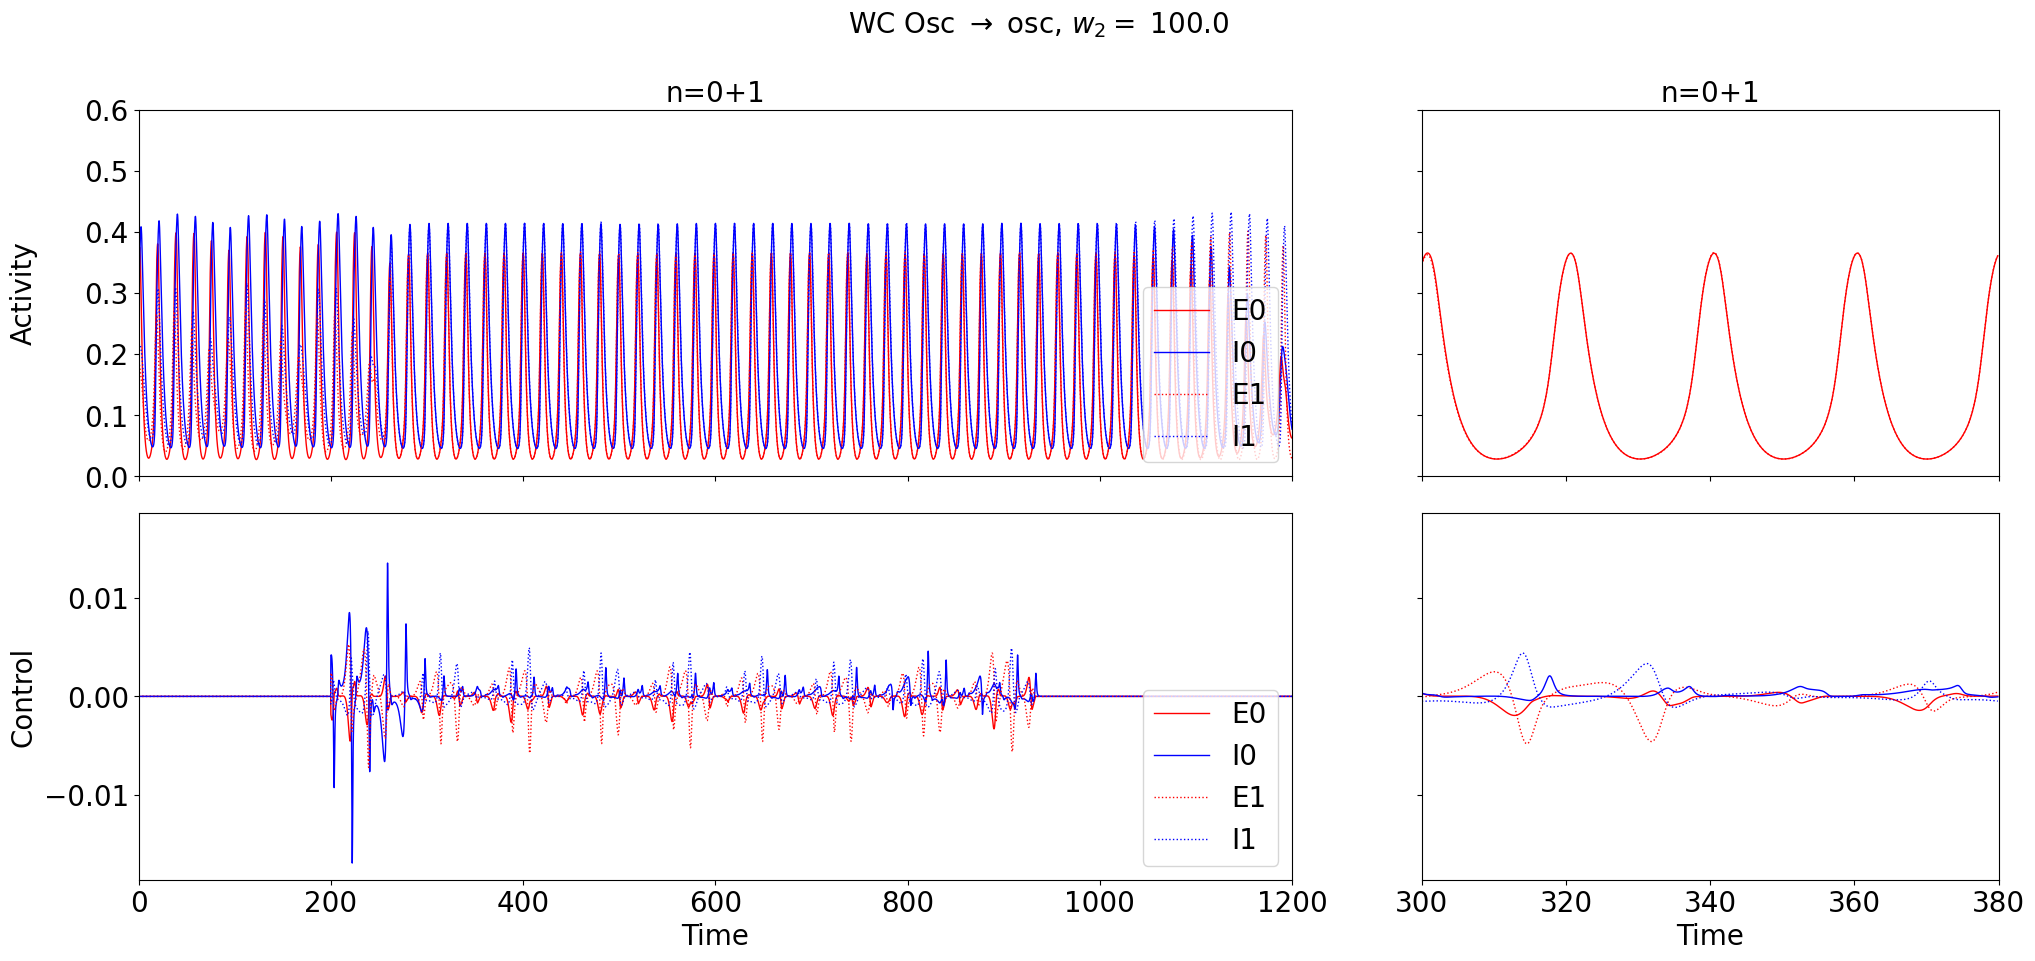

In [127]:
for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" in p:
        continue

    if pi not in [0]: continue

    print("Point ", p)   

    for wi in range(len(data[p]["weight"])):

        print(data[p]["weight"][wi])

        filename = os.path.join(dir, str(p) + "_" + str(wi) + "_1dir.png")
        title = "WC " + p + r" $\rightarrow$ osc, $w_2 = $ " + "{}".format(data[p]["weight"][wi])
        plot_control(data[p],  data[p]["dur/per"][0], dt, wi, filename=filename, title=title)

In [32]:
y0lim = [0, 0.6]

def plot_control_1(c, s, dur, dt, filename=None, title=None):
    fig, ax = plt.subplots(2,2, figsize=(16,6), sharex="col", sharey="row", gridspec_kw={'width_ratios': [2, 1]})
    time_array = np.arange(0, dur+dt, dt)

    cmax = np.amax(np.abs(c))
    y1lim = [-cmax* 1.1, cmax* 1.1]

    ls = ["solid", "dotted"]

    for n in range(N):
        ax[0, 0].plot(time_array, s[n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[0, 0].plot(time_array, s[n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, c[n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, c[n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])

    i0, i1 = 1000, 2000
    time_array = np.arange(i0*dt, i1*dt, dt)
    ax[0, 1].plot(time_array, s[0,0,i0:i1], color="red", label="N0")
    ax[0, 1].plot(time_array, s[1,0,i0:i1], color="red", linestyle=":", label="N1")
    ax[1, 1].plot(time_array, c[0,0,i0:i1], color="red")
    ax[1, 1].plot(time_array, c[1,0,i0:i1], color="red", linestyle=":")
    ax[1, 1].plot(time_array, c[0,1,i0:i1], color="blue")
    ax[1, 1].plot(time_array, c[1,1,i0:i1], color="blue", linestyle=":")

    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(i0*dt, i1*dt)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0+1")
    ax[0,1].set_title("n=0+1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

def plot_control(data, dur, dt, wi, filename=None, title=None):
    fig, ax = plt.subplots(2,2, figsize=(24,10), sharex="col", sharey="row", gridspec_kw={'width_ratios': [2, 1]})
    time_array = np.arange(0, dur+dt, dt)

    cmax = max( np.amax(np.abs(data["control"][0])), np.amax(np.abs(data["control"][1])) )
    y1lim = [-cmax* 1.1, cmax* 1.1]

    ls = ["solid", "dotted"]

    for n in range(N):
        ax[0, 0].plot(time_array, data["state"][wi][n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[0, 0].plot(time_array, data["state"][wi][n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, data["control"][wi][n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, data["control"][wi][n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])

    i0, i1 = 3000, 3800
    time_array = np.arange(i0*dt, i1*dt, dt)
    ax[0, 1].plot(time_array, data["state"][wi][0,0,i0:i1], color="red", label="N0")
    ax[0, 1].plot(time_array, data["state"][wi][1,0,i0:i1], color="red", linestyle=":", label="N1")
    ax[1, 1].plot(time_array, data["control"][wi][0,0,i0:i1], color="red")
    ax[1, 1].plot(time_array, data["control"][wi][1,0,i0:i1], color="red", linestyle=":")
    ax[1, 1].plot(time_array, data["control"][wi][0,1,i0:i1], color="blue")
    ax[1, 1].plot(time_array, data["control"][wi][1,1,i0:i1], color="blue", linestyle=":")

    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(i0*dt, i1*dt)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0+1")
    ax[0,1].set_title("n=0+1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [19]:
with open(os.path.join(pickledir, '2n_wc_oscillations_var.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [116]:
with open(os.path.join(pickledir, '2n_wc_oscillations_var.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['Osc', 'Bi-phase-osc', 'Beat', 'Bi-period-osc', 'Bi-stat-osc'])


In [78]:
y0lim = [0, 0.6]

def plot_control_bi(data, dur, dt, wi, ii, filename=None, title=None):
    fig, ax = plt.subplots(2,2, figsize=(24,10), sharex="col", sharey="row", gridspec_kw={'width_ratios': [2, 1]})
    time_array = np.arange(0, dur+dt, dt)

    cmax = max( np.amax(np.abs(data["control"][ii][0])), np.amax(np.abs(data["control"][ii][1])) )
    y1lim = [-cmax* 1.1, cmax* 1.1]

    ls = ["solid", "dotted"]

    for n in range(N):
        ax[0, 0].plot(time_array, data["state"][ii][wi][n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[0, 0].plot(time_array, data["state"][ii][wi][n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, data["control"][ii][wi][n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, data["control"][ii][wi][n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])

    i0, i1 = 3000, 3800
    time_array = np.arange(i0*dt, i1*dt, dt)
    ax[0, 1].plot(time_array, data["state"][ii][wi][0,0,i0:i1], color="red", label="N0")
    ax[0, 1].plot(time_array, data["state"][ii][wi][1,0,i0:i1], color="red", linestyle=":", label="N1")
    ax[1, 1].plot(time_array, data["control"][ii][wi][0,0,i0:i1], color="red")
    ax[1, 1].plot(time_array, data["control"][ii][wi][1,0,i0:i1], color="red", linestyle=":")
    ax[1, 1].plot(time_array, data["control"][ii][wi][0,1,i0:i1], color="blue")
    ax[1, 1].plot(time_array, data["control"][ii][wi][1,1,i0:i1], color="blue", linestyle=":")

    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(i0*dt, i1*dt)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0+1")
    ax[0,1].set_title("n=0+1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [84]:
data["Bi-period-osc"]["weight"] = [[1. * 1e-1, 1.], [1. * 1e-1, 1.]] # 5 1 e-2 too small/ 5 1e-1 too large
data["Bi-period-osc"]["dur/per"] = [[600., 20], [600., 20]]

Point  Bi-period-osc
target period, max delay =  18.106065544088356 95
duration =  600.0
w2 =  0.1
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -88.53844287086042
Cost in iteration 20: -88.53890101233497
Cost in iteration 40: -88.53948513116195
Cost in iteration 60: -88.54005741350359
Cost in iteration 80: -88.54064152418364
Cost in iteration 100: -88.54121351487268
Final cost : -88.54121351487268
Compute control for a deterministic system
Cost in iteration 0: -88.54121351487268
Cost in iteration 20: -88.54189464815609
Cost in iteration 40: -88.54266408455904
Cost in iteration 60: -88.54332312361481
Cost in iteration 80: -88.54419000333739
Cost in iteration 100: -88.54487781080238
Final cost : -88.54487781080238
Compute control for a deterministic system
Cost in iteration 0: -88.54487781080238
Cost in iteration 20: -88.54548861835823
Cost in iteration 40: -88.54611599649384
Cost in iteration 60: -88.54670188000057
Cost i

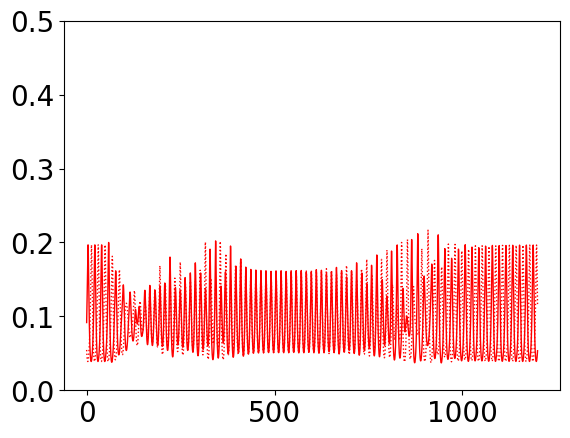

w2 =  1.0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -82.35681335091951
Cost in iteration 20: -82.35746522990526
Cost in iteration 40: -82.35839958638498
Cost in iteration 60: -82.35940775819816
Cost in iteration 80: -82.36029119770606
Cost in iteration 100: -82.36132561517873
Final cost : -82.36132561517873
Compute control for a deterministic system
Cost in iteration 0: -82.36132561517873
Cost in iteration 20: -82.36236837799967
Cost in iteration 40: -82.36380435422133
Cost in iteration 60: -82.36564437303994
Cost in iteration 80: -82.3674838064494
Cost in iteration 100: -82.36932303534553
Final cost : -82.36932303534553
Compute control for a deterministic system
Cost in iteration 0: -82.36932303534553
Cost in iteration 20: -82.37083495845704
Cost in iteration 40: -82.37214817283602
Cost in iteration 60: -82.37328483968928
Cost in iteration 80: -82.37474508978332
Cost in iteration 100: -82.37603811878299
Final cost : 

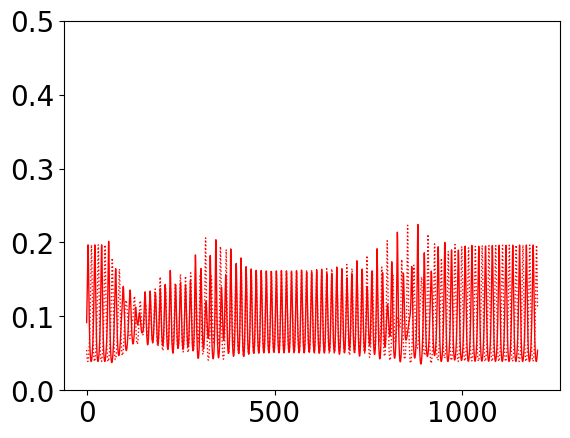

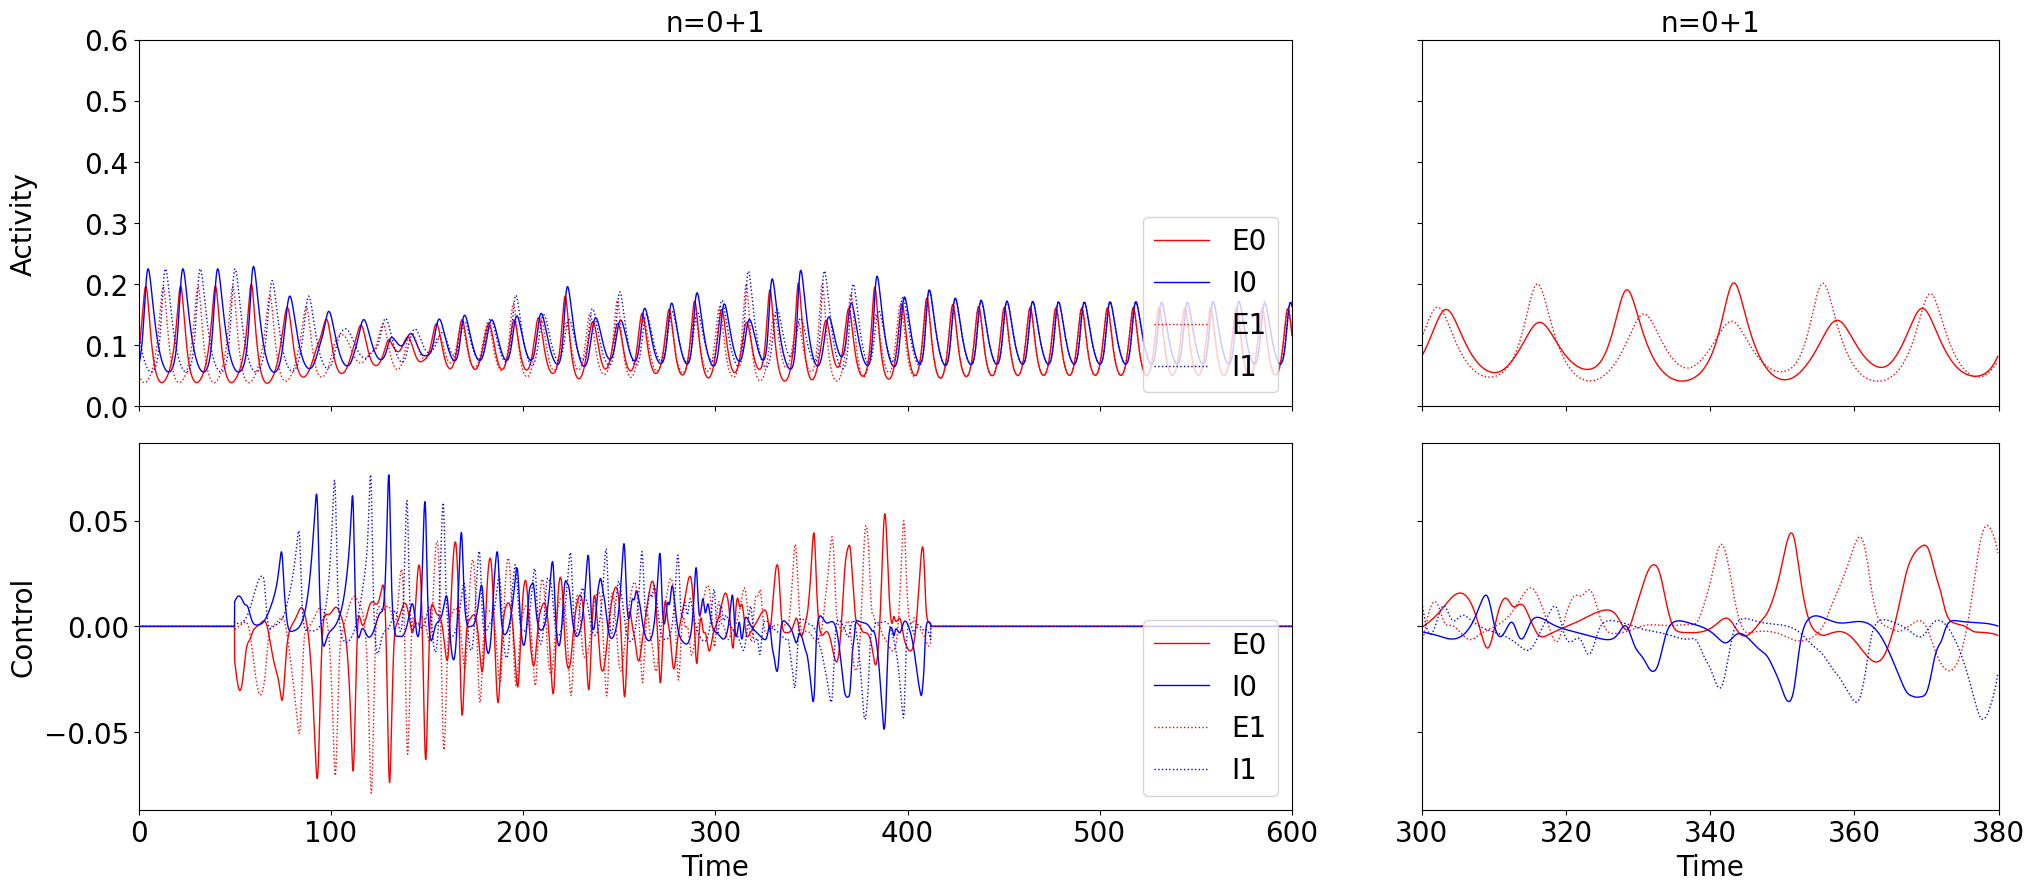

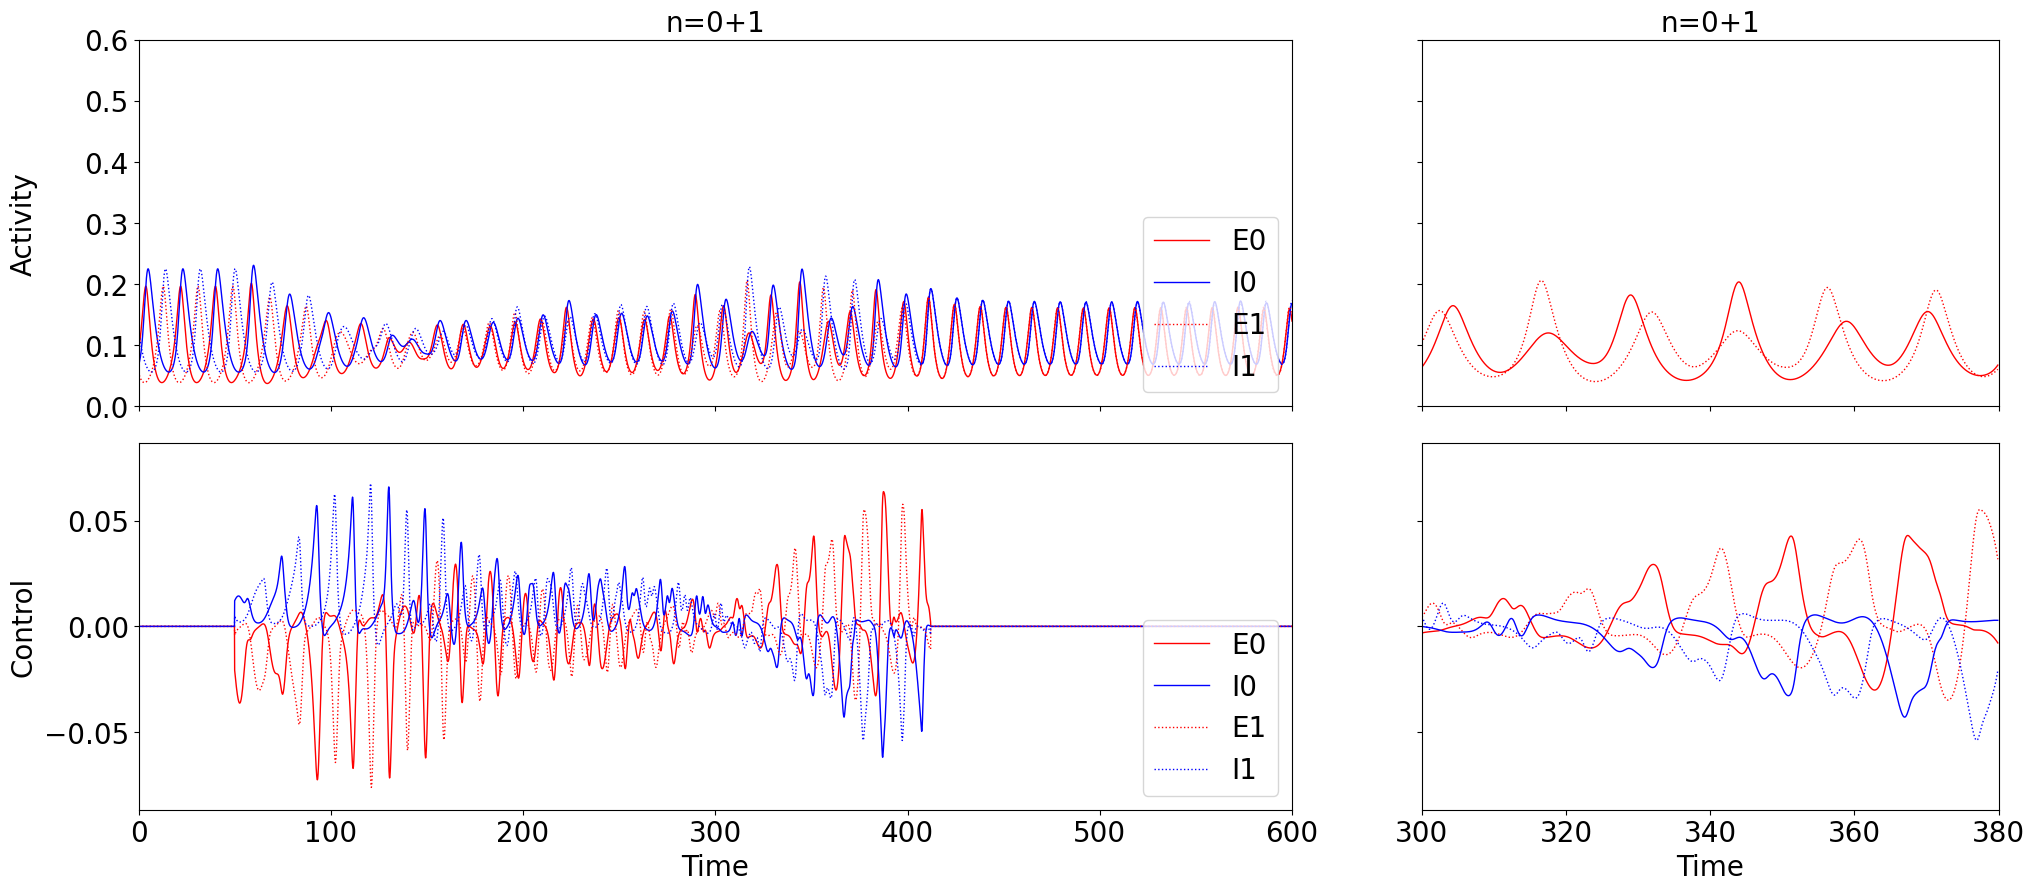

In [98]:
for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" not in p:
        continue

    print("Point ", p)

    for i_init in range(2):

        if i_init not in [1]: continue

        target_period = data[p]["target_period"][i_init]

        model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
        nmaxdelay = model.getMaxDelay()
        print("target period, max delay = ", target_period, nmaxdelay)

        model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
        model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
        model.params.K_gl = coupling
            
        model.params.duration = data[p]["dur/per"][i_init][0]
        print("duration = ", model.params.duration)

        zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
        zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
        zero_control = np.vstack( ([zero_input]*N))
        zero_control = np.vstack( ([zero_input]*N))
        model.params["exc_ext"] = zero_control[:,0,:]
        model.params["inh_ext"] = zero_control[:,1,:]

        model.params["exc_init"] = data[p]["init_state"][i_init][0]
        model.params["inh_init"] = data[p]["init_state"][i_init][1]

        model.run()
        
        int0 = 500
        int1 = int0 + int(data[p]["dur/per"][i_init][1]*target_period/dt)

        for wi, w2 in enumerate(data[p]["weight"][i_init]):

            print("w2 = ",w2)

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2
            model_controlled.weights["w_cc"] = 1.

            model_controlled.maximum_control_strength = maxstr

            if True:
                if type(data[p]["control"][i_init][wi]) != type(None):
                    model_controlled.control = data[p]["control"][i_init][wi].copy()
                    model_controlled.update_input()

            for j in range(10):
                model_controlled.grad_method = 0
                model_controlled.channelwise_optimization = True

                for l in range(1):
                    for k in np.arange(-12., 12., 2.):
                        model_controlled.zero_step_encountered = False
                        model_controlled.step = 10**(k)
                        model_controlled.optimize(it)

                model_controlled.grad_method = 1
                model_controlled.channelwise_optimization = True

                for l in range(1):
                    for k in np.arange(-12., 12., 2.):
                        model_controlled.zero_step_encountered = False
                        model_controlled.step = 10**(k)
                        model_controlled.optimize(10)

            data[p]["control"][i_init][wi] = model_controlled.control.copy()
            data[p]["state"][i_init][wi] = model_controlled.get_xs()

            mod = copy.deepcopy(model_controlled.model)
            mod.params.duration = 1200.
            input = np.zeros((2,2,1+int(mod.params.duration/dt)))
            input[:,:,:1+int(data[p]["dur/per"][i_init][0]/dt)] = model_controlled.control.copy()
            mod.params.exc_ext = input[:,0,:]
            mod.params.inh_ext = input[:,1,:]
            mod.run()

            plt.plot(np.arange(0,mod.params.duration,dt), mod.exc[0,:], color="red")
            plt.plot(np.arange(0,mod.params.duration,dt), mod.exc[1,:], color="red", linestyle=":")
            plt.ylim(0,0.5)
            plt.show()

        plot_control_bi(data[p], data[p]["dur/per"][i_init][0], dt, 0, i_init)
        plot_control_bi(data[p], data[p]["dur/per"][i_init][0], dt, 1, i_init)

with open(os.path.join(pickledir, '2n_wc_oscillations_var.pickle'), 'wb') as f:
    pickle.dump(data, f)

Point  Bi-period-osc
[0.1, 1.0]


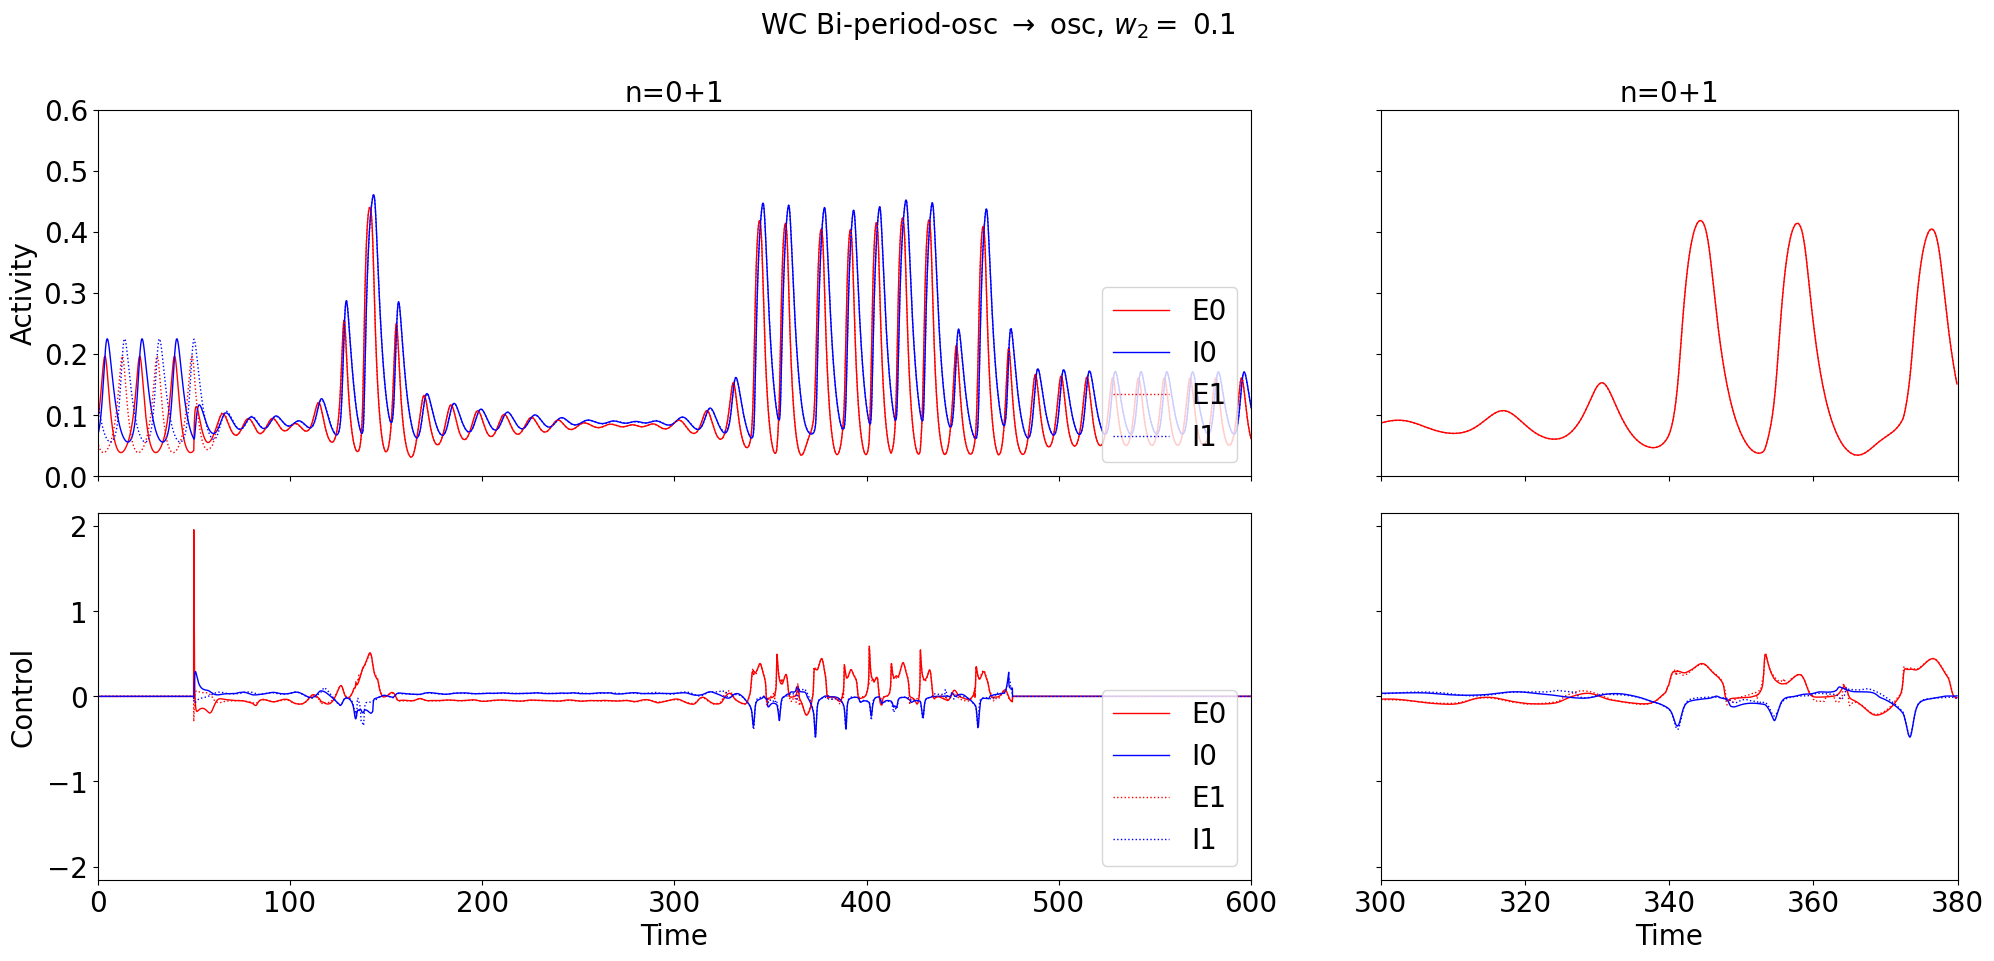

[0.1, 1.0]


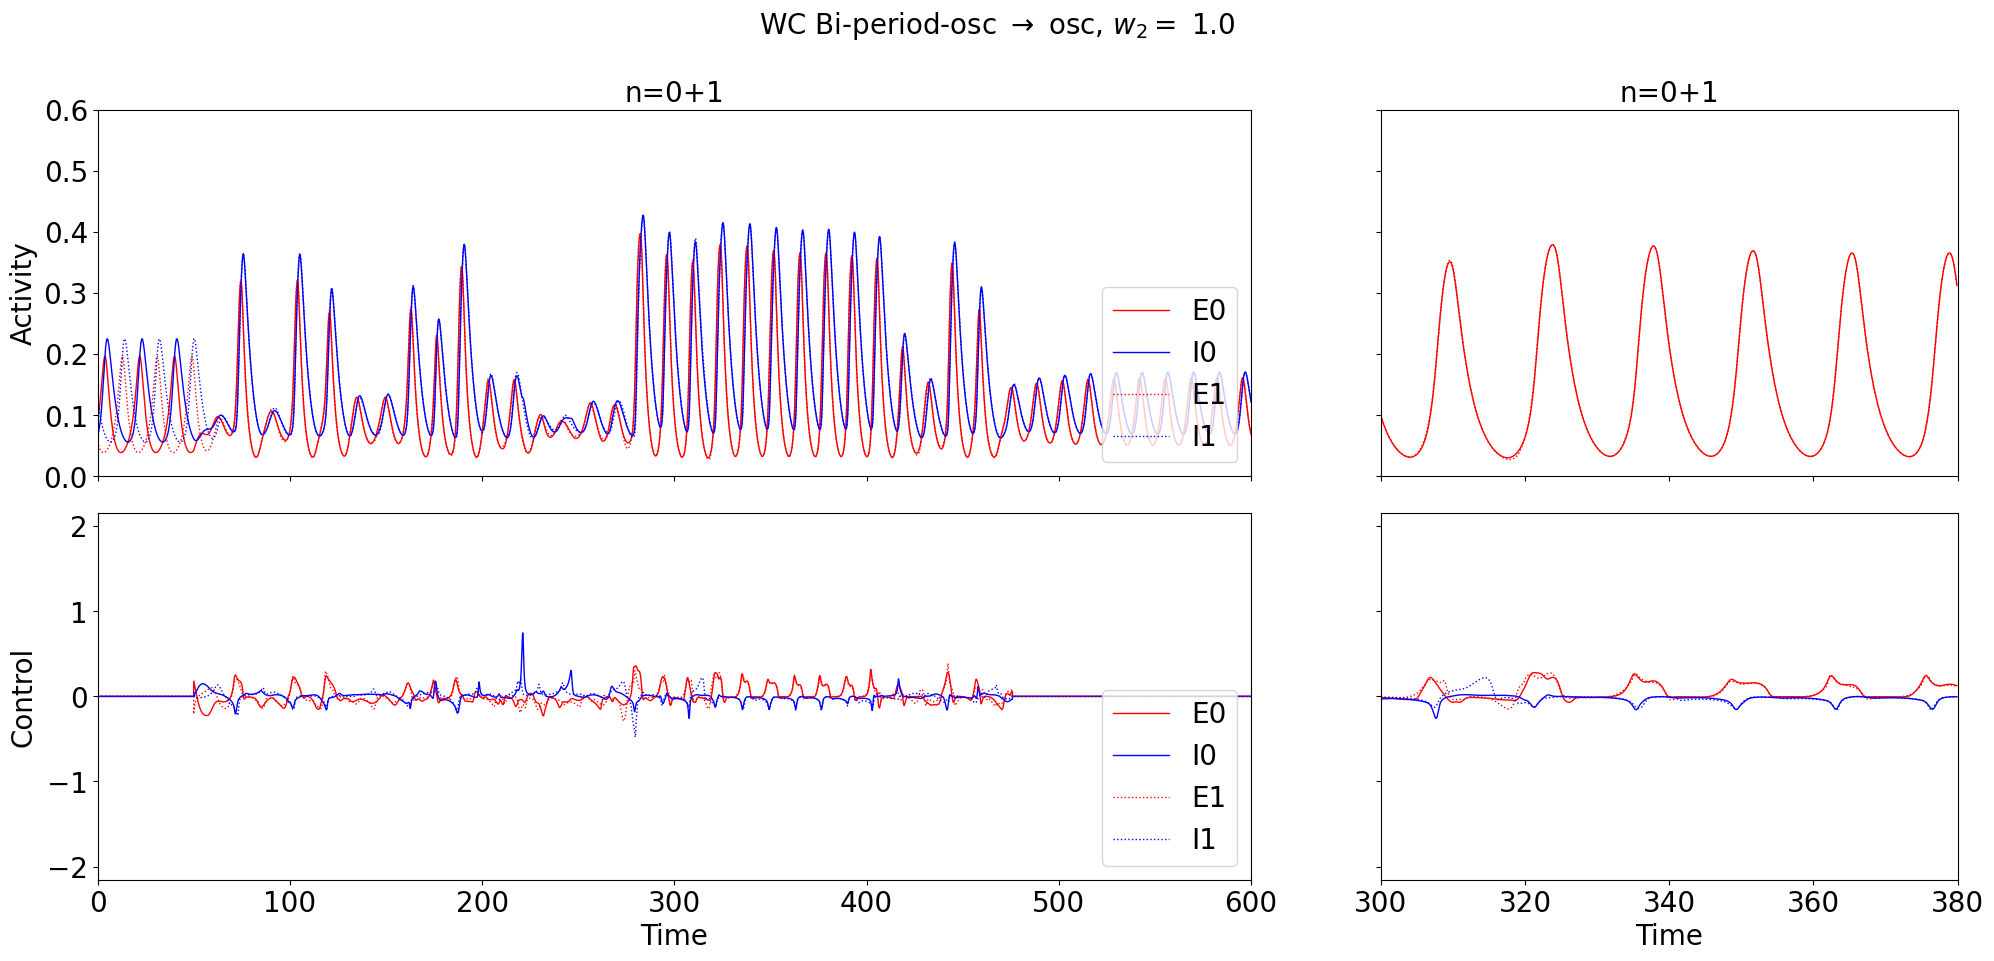

[0.1, 1.0]


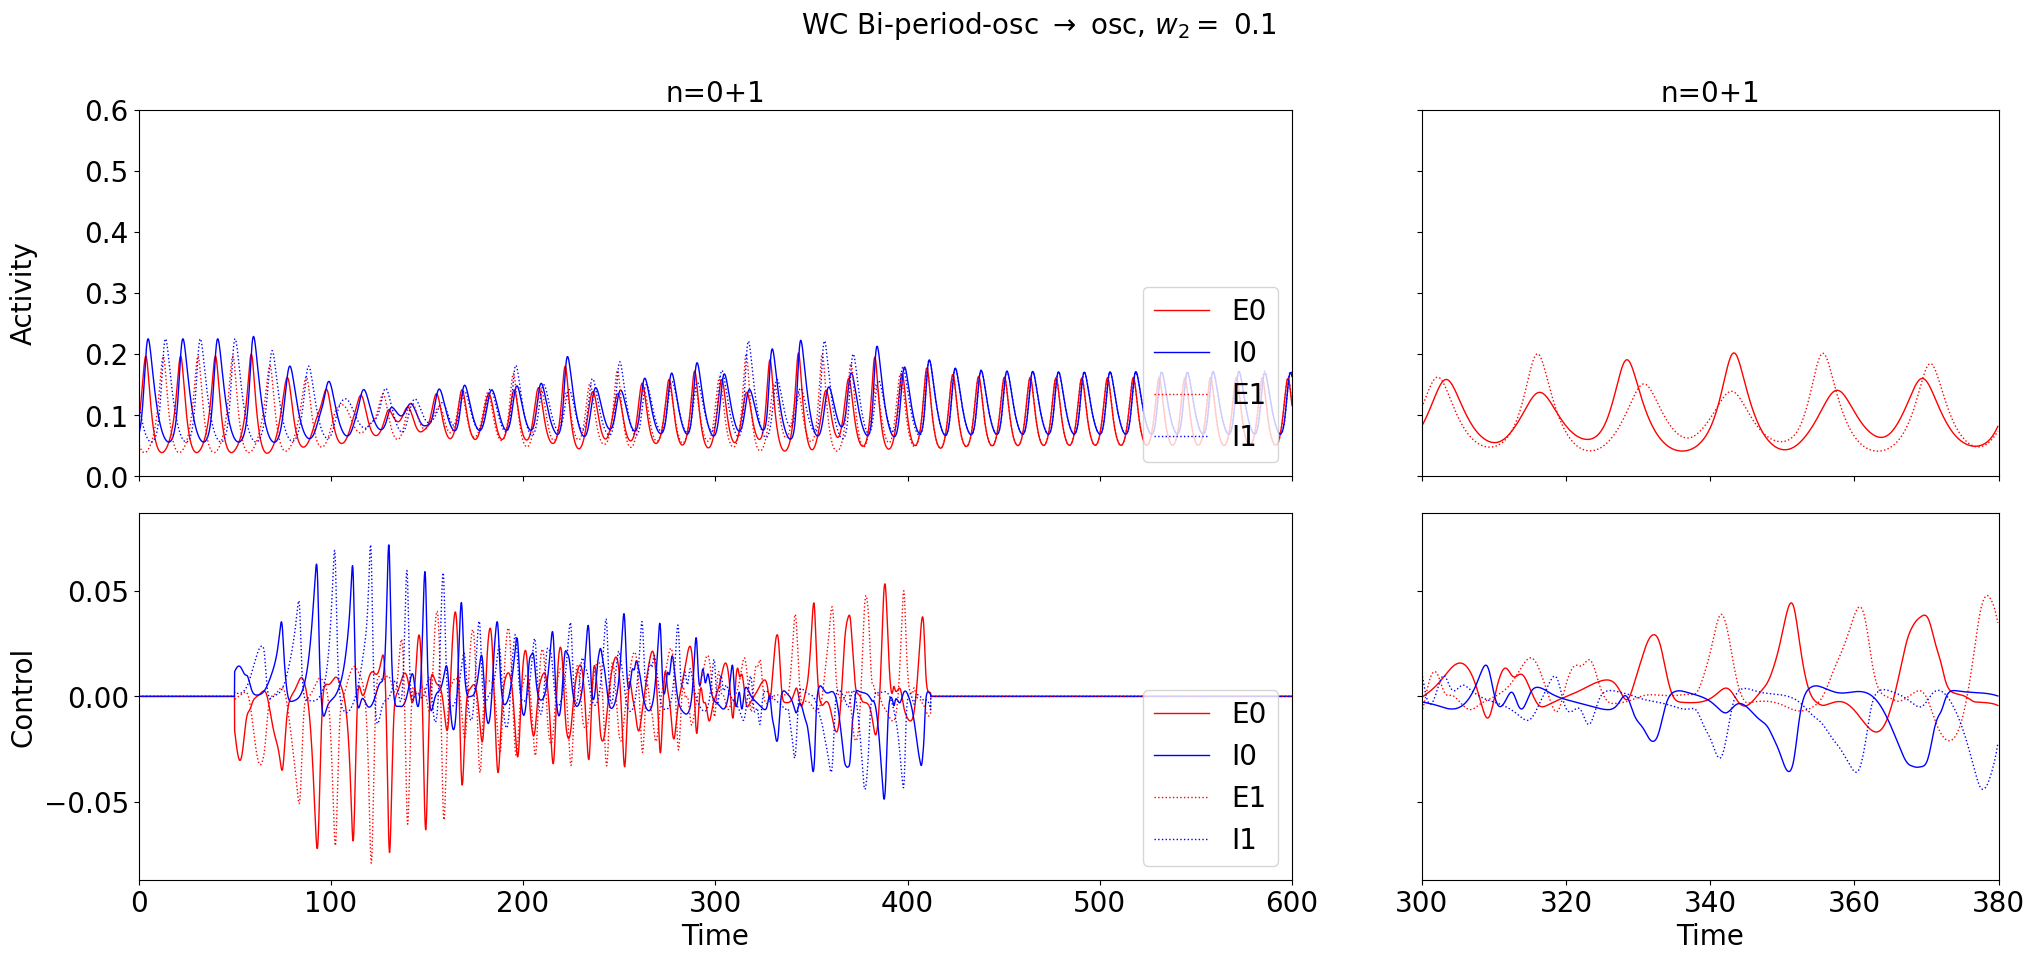

[0.1, 1.0]


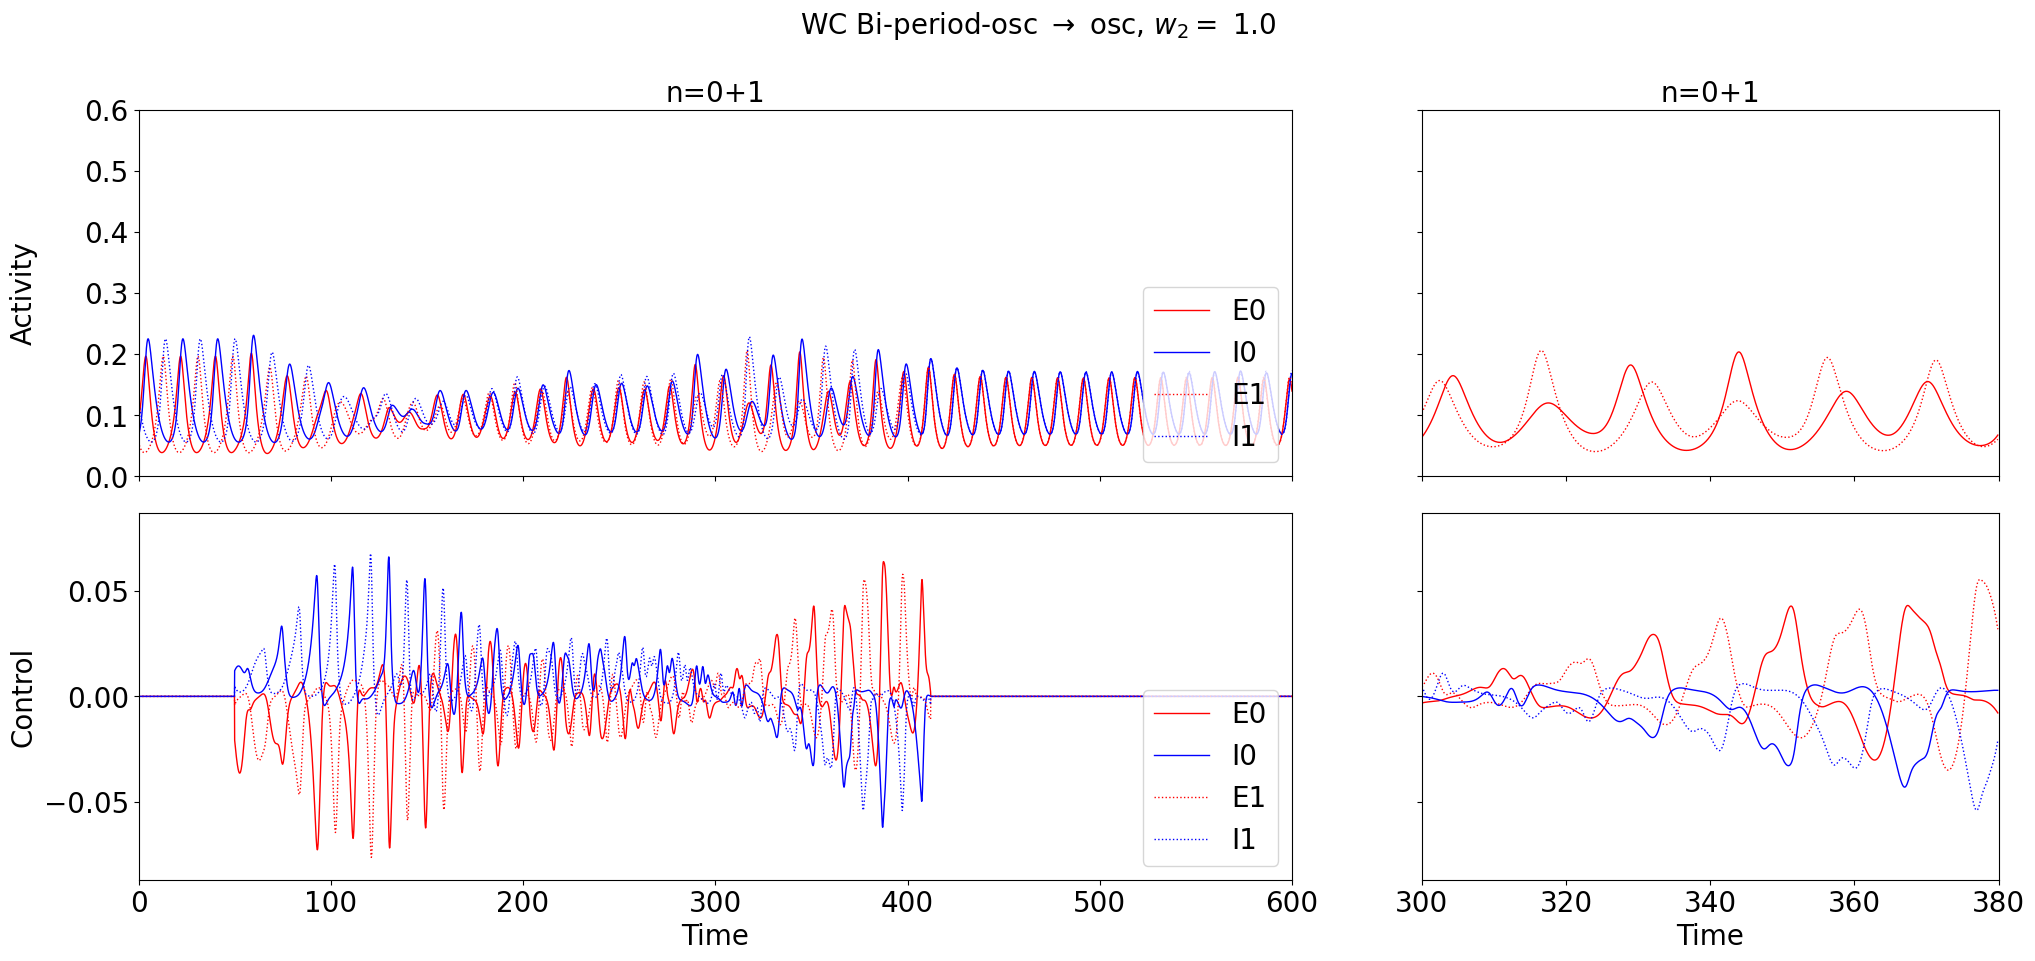

In [99]:
for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" not in p:
        continue

    print("Point ", p)   

    for i_init in range(2):

        for wi in range(len(data[p]["weight"])):

            print(data[p]["weight"][wi])

            filename = os.path.join(dir, str(p) + "_" + str(i_init) + "_" + str(wi) + ".png")
            title = "WC " + p + r" $\rightarrow$ osc, $w_2 = $ " + "{}".format(data[p]["weight"][i_init][wi])
            plot_control_bi(data[p],  data[p]["dur/per"][i_init][0], dt, wi, i_init, filename=filename, title=title)